## Bitcoin Price Prediction with RNN¶
### Library import

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Data Reading

In [57]:
df = pd.read_csv("../DeepLearning/archive_Blockchain/bitstamp_cleaned.csv")

In [58]:
df.head()

,Unix_Timestamp,DateTime,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,12/31/2011 07:52:00,4.390,4.390,4.390,4.390,0.456,2.000,4.390
1,1325346600,12/31/2011 15:50:00,4.390,4.390,4.390,4.390,48.000,210.720,4.390
2,1325350740,12/31/2011 16:59:00,4.500,4.570,4.500,4.570,37.862,171.380,4.526
3,1325350800,12/31/2011 17:00:00,4.580,4.580,4.580,4.580,9.000,41.220,4.580
4,1325391360,01/01/2012 04:16:00,4.580,4.580,4.580,4.580,1.502,6.879,4.580


Data Preparation

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330541 entries, 0 to 3330540
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unix_Timestamp     int64  
 1   DateTime           object 
 2   Open               float64
 3   High               float64
 4   Low                float64
 5   Close              float64
 6   Volume_(BTC)       float64
 7   Volume_(Currency)  float64
 8   Weighted_Price     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 228.7+ MB


In [59]:
df.isnull().sum()


Unix_Timestamp       0
DateTime             0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [60]:
del df['DateTime']

In [61]:
df = df.dropna()
df.head()

,Unix_Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.390,4.390,4.390,4.390,0.456,2.000,4.390
1,1325346600,4.390,4.390,4.390,4.390,48.000,210.720,4.390
2,1325350740,4.500,4.570,4.500,4.570,37.862,171.380,4.526
3,1325350800,4.580,4.580,4.580,4.580,9.000,41.220,4.580
4,1325391360,4.580,4.580,4.580,4.580,1.502,6.879,4.580


In [51]:
# df['date'] = pd.to_datetime(df['Unix_Timestamp'],unit='s').dt.date
# group = df.groupby('date')
real_price = group['Weighted_Price'].mean()

In [52]:
real_price

date
2011-12-31       4.472
2012-01-01       4.807
2012-01-02       5.000
2012-01-03       5.252
2012-01-04       5.208
                ...   
2020-09-10   10339.360
2020-09-11   10303.243
2020-09-12   10373.260
2020-09-13   10393.663
2020-09-14   10332.429
Name: Weighted_Price, Length: 3178, dtype: float64

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330541 entries, 0 to 3330540
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unix_Timestamp     int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 203.3 MB


In [63]:
df.describe() 


,Unix_Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3330541.000,3330541.000,3330541.000,3330541.000,3330541.000,3330541.000,3330541.000,3330541.000
mean,1488481347.023,4056.085,4058.902,4053.083,4056.039,9.616,30652.996,4056.035
std,69846870.878,4104.887,4108.199,4101.295,4104.831,31.610,107030.851,4104.835
min,1325317920.000,3.800,3.800,1.500,1.500,0.000,0.000,3.800
25%,1427606520.000,421.550,421.720,421.370,421.550,0.386,383.049,421.531
50%,1497076440.000,2389.260,2390.980,2386.350,2389.270,1.940,2936.700,2388.988
75%,1548932580.000,7583.000,7588.590,7577.480,7582.760,7.430,19336.109,7583.018
max,1600041600.000,19665.760,19666.000,19649.960,19665.750,5853.852,10445987.794,19663.299


In [64]:
df.corr()

,Unix_Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Unix_Timestamp,1.000,0.808,0.808,0.808,0.808,-0.100,0.191,0.808
Open,0.808,1.000,1.000,1.000,1.000,-0.064,0.289,1.000
High,0.808,1.000,1.000,1.000,1.000,-0.064,0.290,1.000
Low,0.808,1.000,1.000,1.000,1.000,-0.065,0.289,1.000
Close,0.808,1.000,1.000,1.000,1.000,-0.064,0.289,1.000
Volume_(BTC),-0.100,-0.064,-0.064,-0.065,-0.064,1.000,0.435,-0.064
Volume_(Currency),0.191,0.289,0.290,0.289,0.289,0.435,1.000,0.289
Weighted_Price,0.808,1.000,1.000,1.000,1.000,-0.064,0.289,1.000


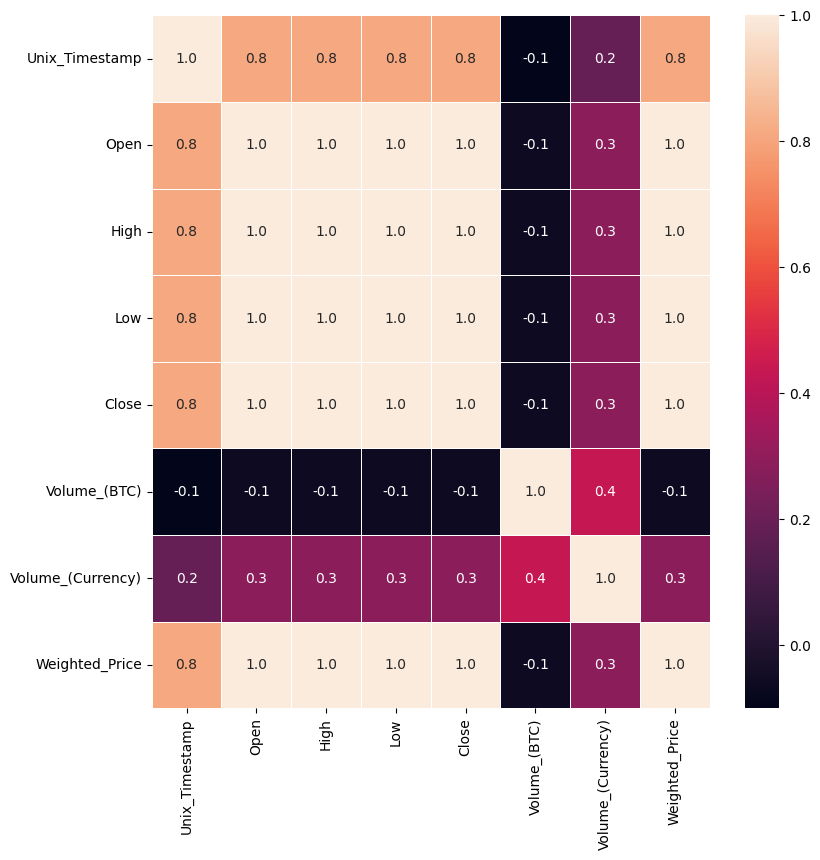

In [65]:
f,ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Visualisierung

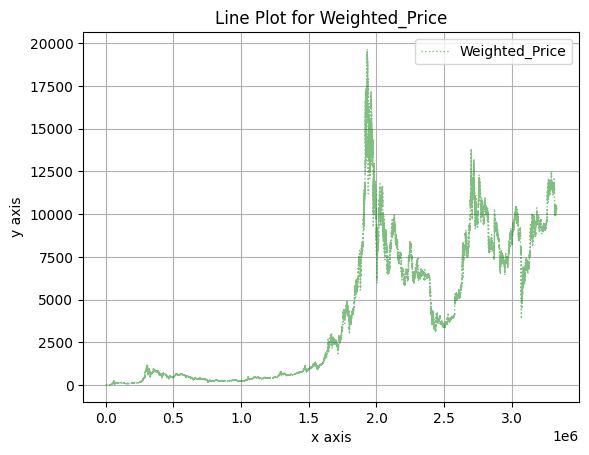

In [66]:
# Line Plot

df.Weighted_Price.plot(kind = "line", color = "g", label = "Weighted_Price",linewidth=1,alpha=0.5,grid=True,linestyle=':')

plt.legend(loc="upper right")   
plt.xlabel("x axis")            
plt.ylabel("y axis")           
plt.title("Line Plot for Weighted_Price") 

plt.show()

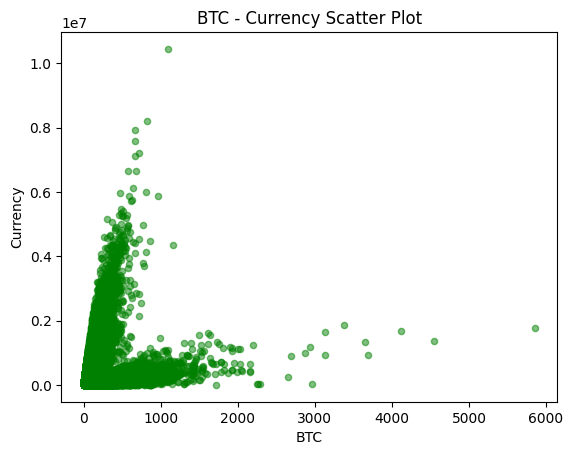

In [67]:
# Scatter Plot 
# x = Volume_(BTC), y = Volume_(Currency)
df.plot(kind='scatter', x='Volume_(BTC)', y='Volume_(Currency)',alpha = 0.5,color = 'green')
plt.xlabel('BTC')              
plt.ylabel('Currency')
plt.title('BTC - Currency Scatter Plot')
plt.show()

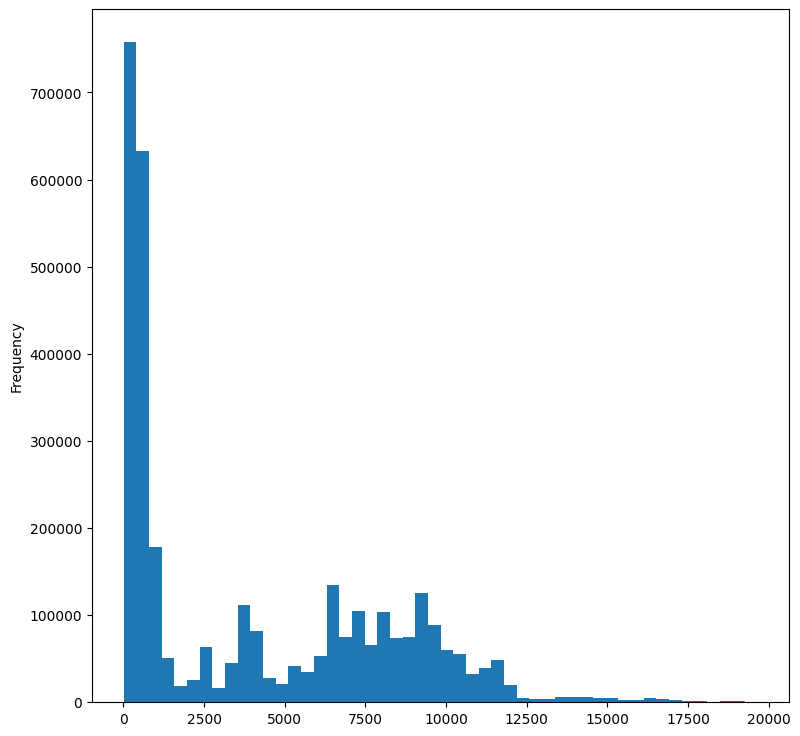

In [68]:
# Histogram
# bins = number of bar in figure
df.Weighted_Price.plot(kind = 'hist',bins = 50,figsize = (9,9))
plt.show()

Timesteps Preparation

In [69]:
# split data
prediction_days = 30
df_train=real_price[:len(real_price)-prediction_days]
df_test=real_price[len(real_price)-prediction_days:]

In [70]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [71]:
### Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [72]:
# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
# epoch= 250

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0181
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 13/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 14/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 15/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoc

Making the predictions

In [73]:
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_btc_price = regressor.predict(inputs)
predicted_btc_price = sc.inverse_transform(predicted_btc_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Visualisierung the Results

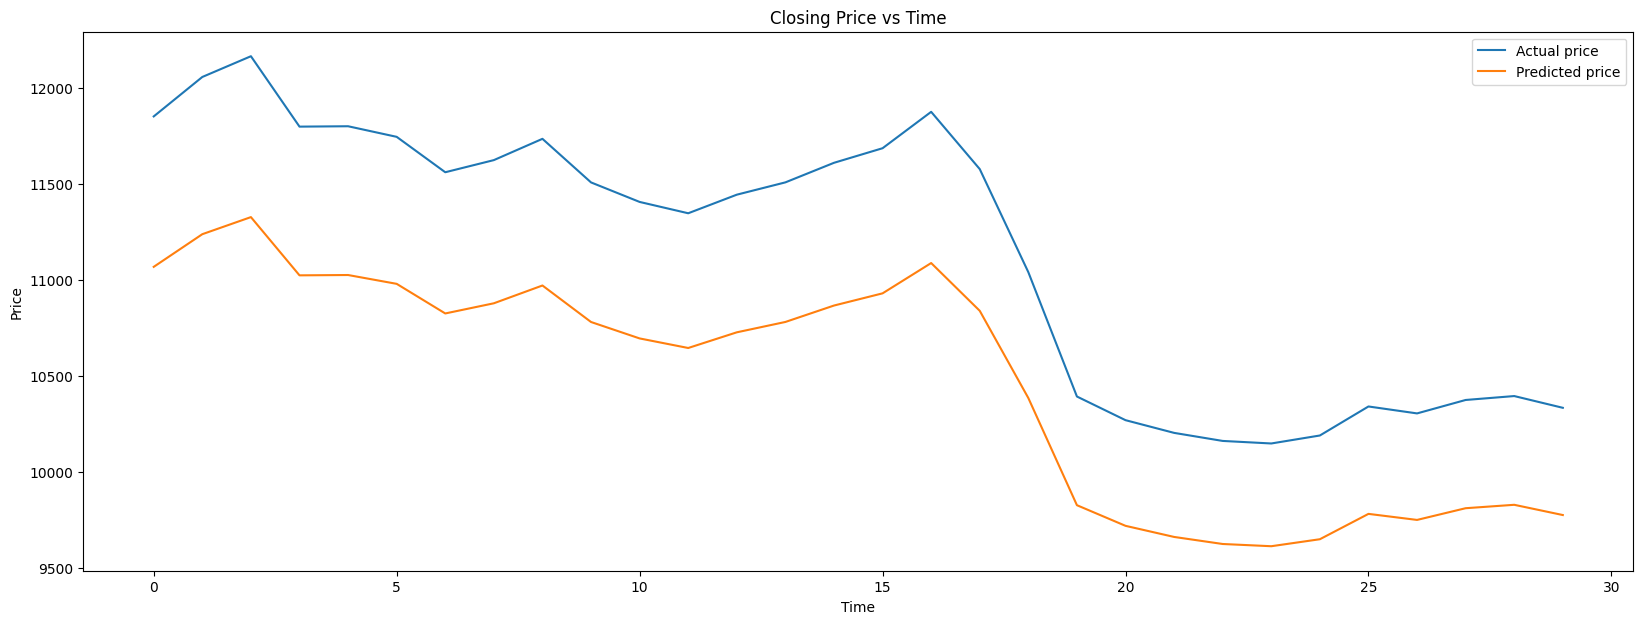

In [74]:
plt.figure(figsize = (20,7))
plt.plot(test_set)
plt.plot(predicted_btc_price)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Closing Price vs Time')
plt.legend(['Actual price', 'Predicted price'])
plt.show()